# In-Depth Analysis of Global Earthquakes and Magnitude Prediction

## 1. Introduction
Earthquakes are a powerful and often destructive natural phenomenon. Understanding their patterns, characteristics, and what influences their magnitude is a critical area of study. This notebook presents a comprehensive analysis of a global earthquake dataset. Our goal is to uncover insights from the data through exploratory analysis and to build a machine learning model capable of predicting earthquake magnitudes based on their geographical and physical properties.

## 2. Load Data and Initial Exploration
We begin by loading the dataset and performing an initial exploration to understand its structure and contents. This first step is crucial for getting a feel for the data we are working with.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset from the CSV file
df = pd.read_csv('all_month.csv')

# Display the first five rows to get a quick overview of the data
print("First 5 rows of the dataset:")
print(df.head())

# Get a concise summary of the dataframe, including data types and non-null values
print("Dataset Information:")
print(df.info())

# Generate descriptive statistics to understand the central tendency and dispersion
print("Summary Statistics:")
print(df.describe())

First 5 rows of the dataset:
                       time   latitude   longitude  depth   mag magType   nst  \
0  2025-07-27T02:44:48.200Z  33.234000 -116.369833   3.30  0.79      ml  37.0   
1  2025-07-27T02:32:44.490Z  57.964200 -157.194700  16.20  2.00      ml   NaN   
2  2025-07-27T02:25:38.642Z  62.253400 -148.284900  23.70  1.90      ml   NaN   
3  2025-07-27T02:24:16.473Z  60.071500 -152.247100  74.90  1.50      ml   NaN   
4  2025-07-27T02:05:49.150Z  35.091833 -119.050000  10.47  1.72      ml  51.0   

    gap     dmin   rms  ...                   updated  \
0  53.0  0.05231  0.24  ...  2025-07-27T02:48:09.947Z   
1   NaN      NaN  0.33  ...  2025-07-27T02:34:12.649Z   
2   NaN      NaN  0.50  ...  2025-07-27T02:27:32.552Z   
3   NaN      NaN  0.42  ...  2025-07-27T02:26:08.614Z   
4  44.0  0.18370  0.26  ...  2025-07-27T02:16:49.100Z   

                               place        type horizontalError depthError  \
0      2 km S of Borrego Springs, CA  earthquake            0.

## 3. Data Cleaning
The initial exploration reveals several columns that are not needed for our analysis, as well as some missing values. In this step, we'll clean the data by dropping unnecessary columns and handling missing values to prepare it for further analysis.

In [6]:
# Drop columns that are not relevant to our magnitude prediction task
df = df.drop(columns=['nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource'])

# The 'time' column is loaded as an object; we convert it to a datetime format for time-series analysis
df['time'] = pd.to_datetime(df['time'])

# Check for missing values in the cleaned dataset
print("Missing values after cleaning:")
print(df.isnull().sum())

Missing values after cleaning:
time         0
latitude     0
longitude    0
depth        0
mag          2
magType      2
place        0
dtype: int64


## 4. Feature Engineering
To improve our model's predictive power, we can create new features from existing ones. In this section, we'll extract detailed time-based features from the `time` column and geographical information from the `place` column.

In [7]:
# Extracting time-based features like year, month, day, and day of the week
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['dayofweek'] = df['time'].dt.dayofweek

# Extracting the country or state from the 'place' column for location-based analysis
df['country'] = df['place'].str.split(', ').str[-1]
print("Dataset after feature engineering:")
print(df.head())

Dataset after feature engineering:
                              time   latitude   longitude  depth   mag  \
0 2025-07-27 02:44:48.200000+00:00  33.234000 -116.369833   3.30  0.79   
1 2025-07-27 02:32:44.490000+00:00  57.964200 -157.194700  16.20  2.00   
2 2025-07-27 02:25:38.642000+00:00  62.253400 -148.284900  23.70  1.90   
3 2025-07-27 02:24:16.473000+00:00  60.071500 -152.247100  74.90  1.50   
4 2025-07-27 02:05:49.150000+00:00  35.091833 -119.050000  10.47  1.72   

  magType                              place  year  month  day  dayofweek  \
0      ml      2 km S of Borrego Springs, CA  2025      7   27          6   
1      ml        29 km SSE of Egegik, Alaska  2025      7   27          6   
2      ml      51 km N of Chickaloon, Alaska  2025      7   27          6   
3      ml  31 km WNW of Happy Valley, Alaska  2025      7   27          6   
4      ml         20 km NNW of Grapevine, CA  2025      7   27          6   

  country  
0      CA  
1  Alaska  
2  Alaska  
3  Alaska

## 5. Exploratory Data Analysis (EDA)
With our data cleaned and enriched, we can now perform a detailed exploratory data analysis. We'll use various visualizations to understand the distributions of key variables and the relationships between them.

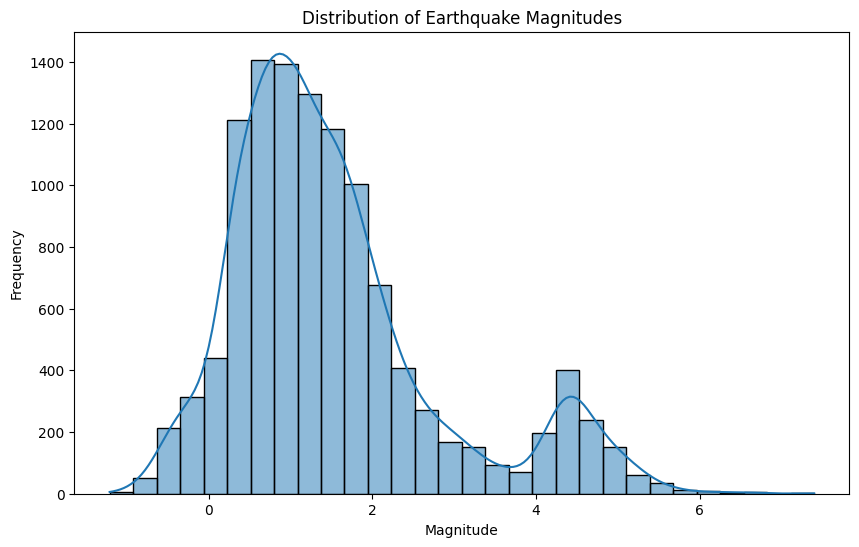

In [8]:
# Distribution of Magnitude
plt.figure(figsize=(10, 6))
sns.histplot(df['mag'], bins=30, kde=True)
plt.title('Distribution of Earthquake Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.show()

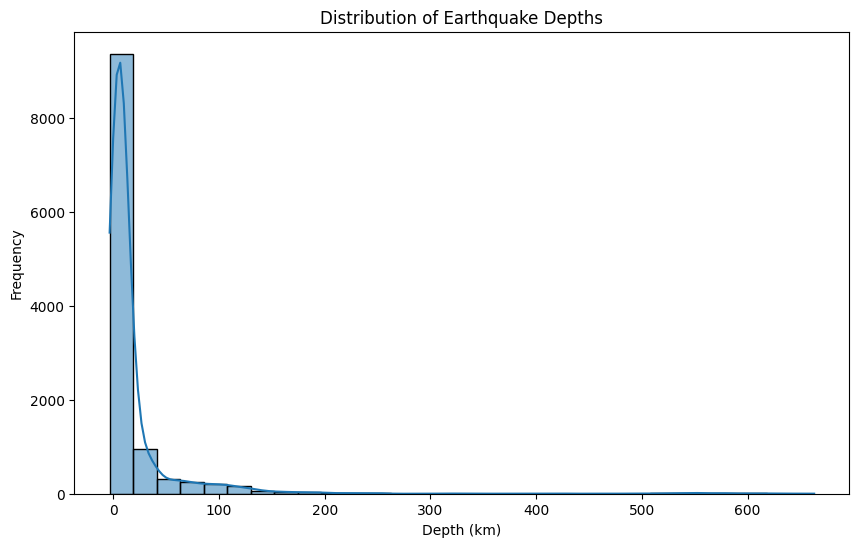

In [9]:
# Distribution of Depth
plt.figure(figsize=(10, 6))
sns.histplot(df['depth'], bins=30, kde=True)
plt.title('Distribution of Earthquake Depths')
plt.xlabel('Depth (km)')
plt.ylabel('Frequency')
plt.show()

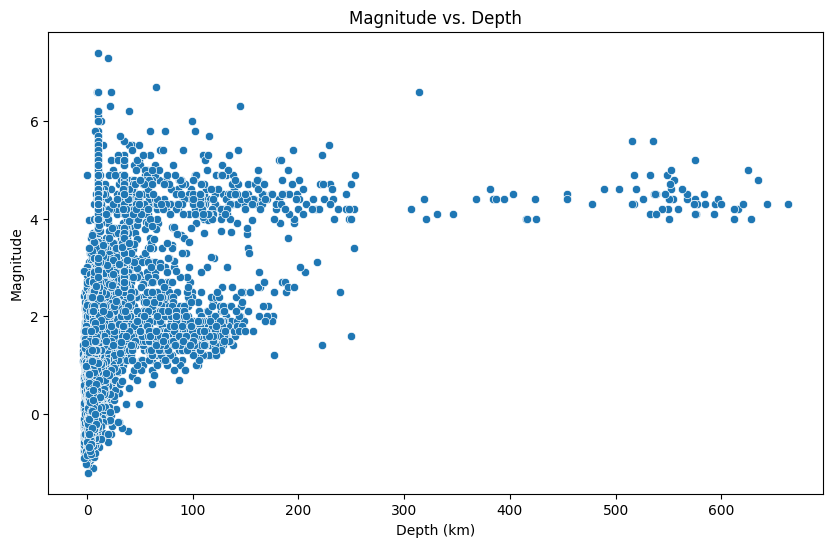

In [10]:
# Magnitude vs. Depth
plt.figure(figsize=(10, 6))
sns.scatterplot(x='depth', y='mag', data=df)
plt.title('Magnitude vs. Depth')
plt.xlabel('Depth (km)')
plt.ylabel('Magnitude')
plt.show()

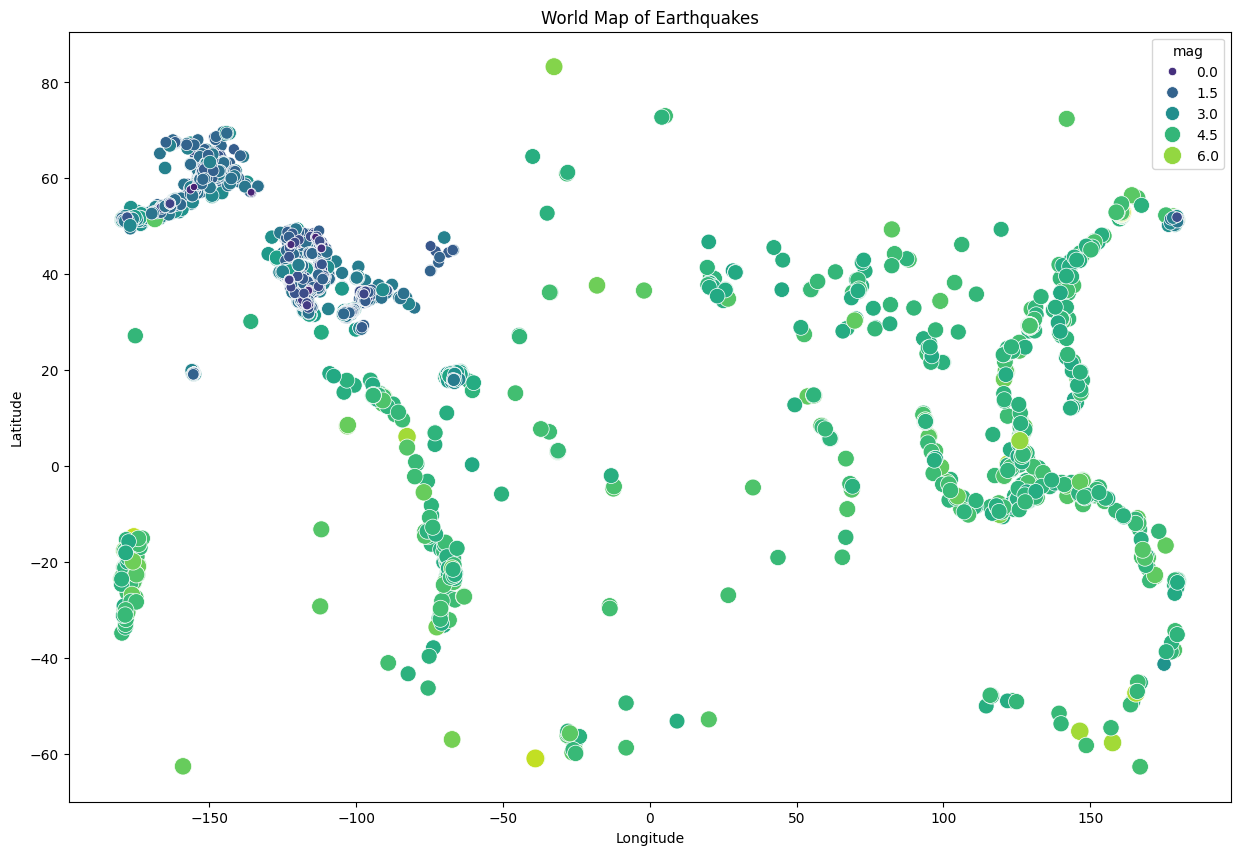

In [11]:
# World map of earthquakes
plt.figure(figsize=(15, 10))
sns.scatterplot(x='longitude', y='latitude', hue='mag', size='mag', data=df, palette='viridis', sizes=(10, 200))
plt.title('World Map of Earthquakes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## 6. Machine Learning Model for Magnitude Prediction 
Now we'll build a machine learning model to predict earthquake magnitudes. We'll use a `RandomForestRegressor`, a powerful ensemble model, and evaluate its performance using cross-validation for a more robust assessment.

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Select the features and target variable for our model
features = ['latitude', 'longitude', 'depth', 'year', 'month', 'day', 'dayofweek']
target = 'mag'

# Drop rows with any missing values in our selected features and target
df_ml = df.dropna(subset=features + [target])

X = df_ml[features]
y = df_ml[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Perform 5-fold cross-validation to get a more reliable measure of the model's performance
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f'Cross-validation R-squared scores: {scores}')
print(f'Average cross-validation R-squared: {np.mean(scores)}')

Mean Squared Error: 0.23418466105580135
R-squared: 0.8591144254393441
Cross-validation R-squared scores: [0.86173393 0.79454599 0.80430642 0.84533828 0.80925939]
Average cross-validation R-squared: 0.8230368031063154


## 7. Model Evaluation 
To visually assess the performance of our model, we can create a scatter plot that compares the actual magnitude values with the magnitudes predicted by our model.

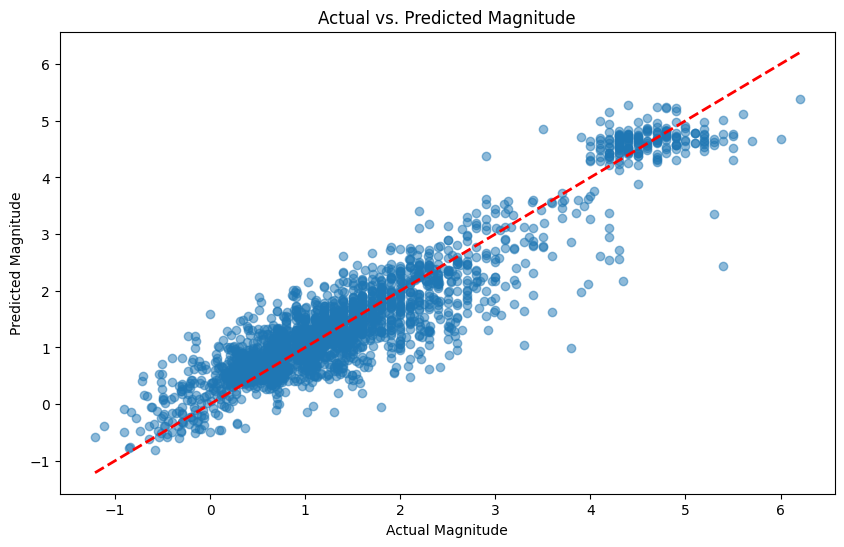

In [14]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Actual vs. Predicted Magnitude')
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude')
plt.show()

## 8. Interactive Map
Finally, to provide a more engaging and interactive way to explore the earthquake data, we'll create a heatmap of earthquake locations using the `folium` library. This map will be saved as an HTML file that you can open in your browser.

In [15]:
# Install folium if it's not already installed
try:
    import folium
except ImportError:
    !pip install folium
    import folium

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Kali-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have pypy3-venv installed.
    
    If you wish to install a non-Kali-packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    For more information, refer to the following:
    * https://www.kali.org/docs/general-use/python3-external-packages/
    * /usr/share/doc/python3.13/README.venv

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Pyt

ModuleNotFoundError: No module named 'folium'

In [ ]:
from folium.plugins import HeatMap

# Create a map centered around the mean latitude and longitude of the earthquakes
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=2)

# Add a heatmap layer to the map, using the magnitude as the weight
HeatMap(data=df[['latitude', 'longitude', 'mag']].dropna(), radius=15).add_to(m)

# Save the map to an HTML file
m.save('earthquake_heatmap.html')

# Display the map in the notebook
m